<img align="left" src="https://quantumspain-project.es/wp-content/uploads/2022/11/Logo_QS_EspanaDigital.png" width="1000px"/><br><br><br><br>



# Fault-tolerant Algorithms

Created: 16/06/2023

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img aling="left" alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />License: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">License Creative Commons Atribución-CompartirIgual 4.0 Internacional</a>.

Internal Reviewers: 
* Alba Cervera ([BSC-CNS](https://www.bsc.es/))
* Andrés Gómez ([CESGA](http://www.cesga.es))

Authors:
* David Castaño ([Scbi-UMA](https://www.scbi.uma.es/site/))
* Javier Sánchez ([Cénits](https://www.cenits.es/))
* Alejandro Cano ([UNICAN](https://web.unican.es/))
* Raúl Fuentes ([BSC-CNS](https://www.bsc.es/))


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
import math
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
%matplotlib inline

<table width="100%">
    <td style="font-size:40px;font-family:Helvetica;text-align:left;background-color:rgba(12, 43, 337, 0.3);">
<b>Shor Algorithm (Qiskit) </b>
</table>  

<table width="100%">
    <td style="font-size:30px;font-family:Helvetica;text-align:left;background-color:rgba(12, 43, 337, 0.3);">
<b>Table of Contents</b>
</table>  

- **[1 - Introduction](#Introduction)**
    - **[1.1 - Cryptography and factorization](#Cryptography-and-factorization)**
    - **[1.2 - Factorization algorithm](#Factorization-algorithm)**
    - **[1.3 - Qualitative Explanation](#Qualitative-Explanation)**
    - **[1.4 - Mathematical Formalism](#Formalism)**
        - **[1.4.1 - Periodicity of $f(x)$](#Periodicity)**
        - **[1.4.2 - Factors of $N$ from period $r$](#Factors-N)**
    - **[1.5 - Period finding by quantum computer](#Period-finding-by-quantum-computer)**


- **[2 - Quantum Fourier Transform (QFT)](#Quantum-Fourier-Transform)**
    - **[2.1 - Formula](#QFT-Formula)**
    - **[2.2 - Circuit](#QFT-Circuit)**

- **[3 - Quantum Phase Estimation](#Quantum-Phase-Estimation)**
    - **[3.1 - Circuit](#Circuit)**
    - **[3.2 - Mathematical Formulation](#Mathematical-Formulation-QPE)**

- **[4 - Shor Algorithm](#Shor-Algorithm)**
    - **[4.1 - Period Finding of a function](#Period-Finding)**
        - **[4.1.1 - The function](#The-function)**
        - **[4.1.2 - Solution: Phase estimation of an operator U](#Solution)**
    - **[4.2 - Implementation (ad hoc) in Qiskit for $N=15$](#Implementation-(ad-hoc)-in-Qiskit)**
       - **[4.2.1 - Case with many shots (inefficient but didactic)](#multishot)**

       - **[4.2.2 - Shot-by-shot case (optimal)](#shot-by-shot)**

- **[5 - Implementation with 2n+3 qubit](#Implementation-2n+3)**
    - **[5.1 - Main idea](#2n+3-Main-idea)**
    - **[5.2 - Explanation in detail](#2n+3-Explanation-in-detail)**
        - **[5.2.1 - Quantum addition algorithm](#2n+3-Addition)**
        - **[5.2.2 - Classical value + quantum log (gate $\phi ADD(a)$)](#2n+3-Gate-phiADD(a))**
        - **[5.2.3 - Modular sum (gate $\phi ADD(a)MOD(N)$)](#2n+3-Gate-phiADD(a)MOD(N))**
        - **[5.2.4 - Modular multiplication (gate $CMULT(a)MOD(N)$)](#2n+3-Gate-CMULT(a)MOD(N))**
        - **[5.2.5 - Controlled gate $C\text{-}U_a$](#2n+3-Gate-C-U_a)**
        - **[5.2.6 - Modular exponentiation (gate $C\text{-}U_{a^{s}}$)](#2n+3-Gate-C-U_a^s)**
        - **[5.2.7 - Final circuit with $4n+2$ qubits (without the simplification of the count register)](#2n+3-Final-circuit-no-simplification)**
        - **[5.2.8 - Final circuit with $2n+3$. The trick of a control qubit)](#2n+3-Simplified-final-circuit)**
    - **[5.3 - Approximate implementation of QFT.](#2n+3-QFT)**
    - **[5.4 - Implementation of controlled SWAPs](#2n+3-SWAP)**

- **[References](#References)**

<a id="Introduction"></a>
<table width="100%">
    <td style="font-size:25px;font-family:Helvetica;text-align:left;background-color:rgba(12, 43, 337, 0.3);">
<b>1 - Introduction </b>
</table>  

<a id="Cryptography-and-factorization"></a>
## 1.1 - Cryptography and factorization

Shor's algorithm is one of the most widely known quantum computing algorithms. It solves a critial problem: factoring an integer number. It provides a great improvement to such task in comparison to the best classical algorithm known to date.

To understand why this algorithm is so important, we must first talk about cryptography. Specifically, the encryption of transmissions over the Internet using the public key and private key method (**asymmetric cryptography**). The conceptual explanation of this way of encrypting is rather simple using an example. When someone wants to access their bank's application, the access codes have to be input (ID and pin). These are sent over the Internet to the headquarters of the bank, which verifies that they are correct and provides access. The core of the problem lies precisely in that connection made through the Internet, where the message containing the access codes can be intercepted. The solution to this problem is encrypting the message such that only the bank can decrypt the message.

The most commonly used encryption method on the Internet is the aforementioned asymmetric cryptography. In this type of encryption, the receiver of the message (in the example, the bank) generates two mutually dependent keys, one of which is published to the outside world (public key) and the other one is known only to him (private key). If someone wants to receive an encrypted message, it would be enough for them to publish the public key so that anyone who wants to send him a message can use it to encrypt it. On the other hand, the private key is only known to the receiver of the message, and is used for decryption. The public key may be thought as a lock and the private key as the key. Anyone can close the lock, but only someone with the key can open it.

The way this implementation is carried out technically is the following: the private key is composed by two prime numbers (of large size, hundreds of digits), and the public key is the product of these two numbers. The strength of this encryption method (RSA) lies in the fact that if we have two prime numbers finding the product is computationally very easy and not demanding. However, the opposite is not that easy at all. In case the multiplication is known (public key) finding the two numbers whose product is the public key (factoring the number into its prime elements) is extremely difficult. As expected, the longer the key is, the longer it takes to factor it. The complexity of the problem lies specifically in the fact that the time required to factor the number grows **exponentially** with the number of bits. Finding the factors of the actual keys given the lengths currently handled would take hundreds or thousands of years even with the best supercomputers.

The tremendous power and applicability of Shor's algorithm is that it converts this problem of exponential complexity for a classical computer into a problem of polynomial complexity for a quantum computer. That is, with Shor's algorithm the time required (time complexity) to factor a number grows **polynomially** with the number of digits in the number. Thus, if there were an available quantum computer with enough qubits to apply this algorithm to numbers of the key length currently used, it would be possible to find the private key in a reasonable time for the human scale. Shor's algorithm has the potential to break asymmetric cryptography and make network communications vulnerable. However, current quantum computers are far from having the capacity of implementing it on the scale required. It is estimated that it would take on the order of a million qubits, whereas the largest quantum computers are currently (year 2022) on the order of hundreds of qubits.

<a id="Factorization-algorithm"></a>
## 1.2 - Factorization algorithm

Shor's algorithm is based on the result that holds that a factorization problem can be reduced to a **period (or order) finding problem**. Before talking about quantum, an explanation on the general structure of a factorization algorithm of this form is shown, as described in the [Nielsen-Chuang](#Bibliography), commenting on where quantum computation comes in to speed it up.

Firstly, the notion of **coprime numbers** is introduced: two numbers $a$ and $b$ are coprime if their greatest common divisor is 1, i.e., gcd$(a,b) = 1$. That is, two coprime numbers share only 1 as common divisor. 

The steps to reduce a factorization problem into a period finding problem are the following. Let $N$ be the number to factorize.

- 1. If $N$ is even, return the factor 2.

- 2. Determine whether $N=p^b$ for the integers $p \geq 1$ and $b \geq 2$. If so, return the factor $p$ (this can be done in polynomial time).

- 3. Choose a random integer $a$ such that $1 < a \leq N-1$. Using Euclid's algorithm, determine if gcd$(a,N) > 1$. If it is, return the factor gcd$(a,N)$.

- 4. If gcd$(a,N) = 1$, calculate the period $r$ of the function $f(x) = a^x \text{ mod} N$.

- 5. If $r$ is odd or $r$ is even and $a^{r/2} \text{ mod} N =-1$, we go back to step 3. Otherwise, if $r$ is even and $a^{r/2} \text{ mod} N \neq-1$,  we calculate gcd$(a^{r/2}-1,N)$ and gcd$(a^{r/2}+1,N)$. We test whether one of these is a non-trivial factor of $N$, and return that factor if so.

Every step of this algorithm, except **step 4**, can be implemented on a classical computer and solved in polynomial time. This is because to compute the greatest common divisor you can use the [Euclid Algorithm](https://en.wikipedia.org/wiki/Euclidean_algorithm#Algorithmic_efficiency), which solves the problem in **polynomial time** (it can be computed in a reasonable time).

The complicated step is **step 4**, finding the period of the function. To date there is no way to implement it in polynomial time (it is implemented in **exponential time**) on a classical computer. However, this step can be implemented on a quantum computer in polynomial time. So the optimal way to factor a number is to implement steps 1, 2, 3 and 5 on a classical computer, and step 4 on a quantum computer.

No further comments will be provided regarding steps 1, 2 and 3 in this document, as they are not very complex. The focus will be on the mathematical formalism of steps 4 and 5, and the implementation of step 4 on a quantum computer.

<a id="Qualitative-Explanation"></a>
## 1.3 - Qualitative Explanation

In this section we provide a qualitative explanation on the way of finding the factors of a number by calculating the period of a function. In section [1.4 - Mathematical Formalism](#Formalism) further details will be provided to the statements made in this section.

The function we are interested in is the following:

\begin{equation}
f(x) = a^x \text{ mod} N
\end{equation}

where $a$ and $N$ are positive integers greater than 1, with $a$ < $N$ and having no common factors (i.e., $\gcd(a,N) = 1$). The operation ($z$ mod$N$) is modular $N$, and it returns the **remainder** of dividing $z$ by $N$. The function $f(x) = a^x \text{ mod} N$ is called **modular exponentials** (it calculates an exponential and applies a modular operation). It belongs to the **modular arithmetic** and if the conditions on $a$ and $N$ are satisfied the function is periodic. The value of the period of the function $f(x)$ will be denoted $r$, i.e. the minimum integer value for which the following is satisfied:
    
$$
f(x+r) = f(x).
$$  

This can be calculated in polynomial time by means of a quantum circuit.

Once $r$ is known, if is even (otherwise the algorithm needs to be repeated with a different $a$), factors of $N$ can be calculated. That is because
$$
a^r \text{ mod} N = 1
$$
so
$$
(a^r-1) \text{ mod} N = 0
$$
Hence, $N$ is a divisor of $a^r-1$. If $r$ is even (otherwise repeat with a different $a$), the following decomposition can be made:
$$
a^r-1 = (a^{r/2}-1)(a^{r/2}+1)
$$
Then, with a notable probability (which depends on the number of different factors of $N$), the **greatest common factor** of $N$ and $a^{\,r/2}-1$, $\gcd(N, a^{\,r/2}-1)$, or the **greatest common factor** of $N$ and $a^{\,r/2}+1$, $\gcd(N, a^{\,r/2}+1)$, is a non-trivial factor of $N$.

<a id="Formalism"></a>
## 1.4 - Mathematical Formalism

Let us expand on the mathematical formalism on which the previous statements are based.

<a id="Periodicity"></a>
### 1.4.1 - Periodicity of $f(x)$.

To prove that, given the condition $\gcd(a,N) = 1$, the function $f(x) = a^x \text{mod} N$ is periodic is not a trivial task. Several theorems need to be stated and the explanation might become tedious for a reader not very well versed on number theory (refer to Appendix 4 of [Nielsen-Chuang](#Bibliography) for the full proof). In this section a simpler and clarifying explanation is provided starting from the following result (without proving it): 

 - Given the function $f(x) = a^x \text{ mod } N$, if $\gcd(a,N) = 1$, for some integer value $z>0$ it holds that $f(z) = a^z \text{ mod } N = 1$. 

We see now that the smallest value $z>0$ for which $f(z) = a^z \text{mod} N = 1$ is satisfied will be the period of the function, denoted by $r$. It is the first value (greater than zero) for which $f(r) = 1$ is satisfied. We have that 

$$
a^0 =1 \Rightarrow f(0) = a^0 \text{ mod} N = 1 = f(r).
$$ 

Starting from 1, the moment an exponent $r$ such that $a^r \text{ mod } N = 1$ is reached we can therefore write

$$
a^r = \alpha N + 1, \ \alpha\in \mathbb{N}
$$

with which

\begin{align}
f(r+z) & = a^{r+z} \text{ mod} N \\
&= a^r a^z \text{ mod} N  \\
&= (\alpha N + 1)\,a^z \text{ mod} N  \\
&= (\alpha N + 1)\,a^z \text{ mod} N \\ 
& = \alpha N a^z \text{ mod} N + a^z \text{ mod} N  \\
&= a^z \text{ mod} N  \\
&= f(z)
\end{align}

We have thus seen that $f(x)$ is periodic.

<a id="Factors-N"></a>
### 1.4.2 - Factors of $N$ from period $r$

To understand how to obtain the factors of $N$ from the period $r$ of the function $f(x)$ the following theorems are needed, present in [Nielsen-Chuang](#Bibliography).

**Nielsen-Chuang Theorem 5.2**: Suppose $N$ is a composite number of $L$ bits, and $x$ is a nontrivial solution of the equation $a^2 = 1 \text{ mod } N$ in the range $1 \leq a \leq N$, that is, neither $x = 1 \text{ mod } N$ nor $x = N-1 = -1 \text{ mod } N$, hence $1<x<N-1$. Then, one of gcd$(x-1,N)$ and gcd$(x+1,N)$ is a nontrivial factor of $N$ that can be computed using $\mathcal{O}(L^3)$ operations.

- Proof: Since $x^2 = 1 \text{ mod } N \Rightarrow (x^2 -1) = 0 \text{ mod } N$, it must hold that $N$ divides $(x^2-1) = (x+1)(x-1)$, so $N$ must have a common factor with $(x+1)$ or with $(x-1)$. By assumption $1 < x < N-1$, so $0 < x-1 < x+1 < N$, from which we can see that the common factor cannot be $N$ itself. Using [Euclid's Algorithm](https://en.wikipedia.org/wiki/Euclidean_algorithm#Algorithmic_efficiency) we can compute $\gcd(x-1, N)$ and $\gcd(x+1, N)$, and thereby obtain a nontrivial factor of $N$, using $\mathcal{O}(L^3)$ operations.
  
**Nielsen-Chuang Theorem 5.3**: Suppose $N = p^{\alpha_1}_1 \dots p^{\alpha_m}_m $ is the prime factor decomposition of an odd composite positive integer. Let $x$ be an integer chosen uniformly at random, subject to the requirements $1 \leq x \leq N-1$ and $x$ is coprime to $N$. Let $r$ be the order of $x \text{ mod } N$. Then

$$
\mathbb{P}\Big(\{r \text{ is even}\} \cap \{x^{r/2} \neq - 1 \text{ mod} N\}\Big) \geq 1 - \frac{1}{2^m}
$$

i.e., the probability of finding an even $r$ and that it satisfies $x^{r/2} \neq - 1 \text{ mod } N$ is greater than 1 - 1/$2^m$.

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Note<b></span>: In our case theorem 5.2 applies with $x = a^r$ and theorem 5.3 with $x = a$.
    
    
</p>
</span>
</div>

Theorems 5.2 and 5.3 can be combined to produce an algorithm that, with high probability, returns a non-trivial factor of any composite integer $N$. Every step of the algorithm can be realized efficiently with a classical computer, with the exception (until today's knowledge) of a "subroutine" of period finding. Repeating the procedure a complete prime factorization of $N$ can be found.

<a id="Period-finding-by-quantum-computer"></a>
## 1.5 - Period finding by quantum computer

As mentioned above, step 4 described in section [1.2](#Factorization-algorithm) (period finding of $f(x)$) can be implemented efficiently on a quantum computer. This is done by reducing the period search problem to a **Quantum Phase Estimation** problem, which in turn uses the **Quantum Fourier Transform**.

In section [2](#Quantum-Fourier-Transform) we will discuss the Quantum Fourier Transform, in section [3](#Quantum-Phase-Estimation) we will discuss the Quantum Phase Estimation algorithm and in the following sections we will see implementations of Shor's algorithm.

<a id="Quantum-Fourier-Transform"></a>


<table width="100%">
    <td style="font-size:25px;font-family:Helvetica;text-align:left;background-color:rgba(12, 43, 337, 0.3);">
<b>2 - Quantum Fourier Transform </b>
</table>

Quantum Fourier Transform is explained in this section, the way it is applied and which circuit implements it. Further information on QFT can be found in [Qiskit textbook](https://learn.qiskit.org/course/ch-algorithms/quantum-fourier-transform).

<a id="QFT-Formula"></a>
## 2.1 - Formula

Let $n$ be the number of qubits and a state $\left| x \right\rangle = \left| x_1 x_2 \dots x_n \right\rangle$ where $x_1$ is the most significant bit, Quantum Fourier Transform $QFT$ is: 

\begin{align}
QFT \left| x \right\rangle & = \frac{1}{2^{n/2}} \sum_{y=0}^{2^n-1} e^{2 \pi i xy /2^n} \left| y \right\rangle \qquad 
\\ 
& = \frac{1}{2^{n/2}} \left( \left| 0 \right\rangle + e^{\frac{2\pi i}{2}x} \left| 1 \right\rangle \right) \otimes \left( \left| 0 \right\rangle + e^{\frac{2\pi i}{2^2}x} \left| 1 \right\rangle \right) \otimes \dots \otimes \left( \left| 0 \right\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \left| 1 \right\rangle \right) \otimes \left( \left| 0 \right\rangle + e^{\frac{2\pi i}{2^n}x} \left| 1 \right\rangle \right) 
\end{align}

where $\displaystyle\left|y \right\rangle = \left| y_1 y_2 \dots \right\rangle, \, \, \dfrac{y}{2^n} = \sum_{k=1}^n \dfrac{y_k}{2^k}$

Inverse Quantum Fourier Transform of an n-qubit state $|y\rangle $ only differs from the direct transformation on the sign of the exponential:
$$
QFT^{-1} \left| y \right\rangle  = \frac{1}{2^{n/2}} \sum_{x=0}^{2^n-1} e^{-2 \pi i yx /2^n} \left| x \right\rangle 
$$

<a id="QFT-Circuit"></a>
## 2.2 - Circuit

Next figure displays the circuit which implements QFT:



<div style="text-align:center">
<img src="Figuras_Shor/Fig-QFT-1.png" width="1000"/>
</div>

Two kind of gates are applied in QFT, Hadamard gates and $UROT_k$ gates. The controlled version of the later ones are $CROT_k$:

$$
CROT_k = \left[ \begin{matrix}
I & 0 \\
0 & UROT_k
\end{matrix} \right]
$$

$UROT_k$ is a rotation gate:

$$
UROT_k = \left[ \begin{matrix}
1 & 0 \\
0 & \exp \left( \frac{2 \pi i}{2^k} \right)
\end{matrix} \right]
$$

Matrix associated with $CROT_k$ is:

$$
CROT_k = \left[ \begin{matrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & \exp \left( \frac{2 \pi i}{2^k} \right)
\end{matrix} \right]
$$

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red">**Important remark**: Note that this circuit follows the convention most widely used in the literature, i.e., **the most significant bit is the one at the top** and the least significant bit is the one at the bottom. **Qiskit follows the opposite convention**.</span> Given a state

$$
\left| x \right\rangle = \left| a_{n-1} a_{n-2} \dots a_1 a_0 \right\rangle
$$

which can be written in decimal base as:

$$
x = a_{n-1} 2^{n-1} + a_{n-2} 2^{n-2} + \dots + a_0 2^{0}
$$
    
the circuits follow opposite ordering in the qubits:
    
<div style="text-align:center">
<img src="Figuras_Shor/Fig-2_conventions_English.png" width="300"/>
</div>
    

In this case, to write the circuit using qiskit convention it is needed to invert the qubits controlling the $U$ gates, i.e., apply $U^{2^{t-1}}$ controlled by the last qubit, $U^{2^{t-2}}$ controlled by the second-to-last qubit, ..., and $U^{2^{0}}$ controlled by the first qubit.
    
    
</p>
</span>
</div>

<a id="Quantum-Phase-Estimation"></a>

<table width="100%">
    <td style="font-size:25px;font-family:Helvetica;text-align:left;background-color:rgba(12, 43, 337, 0.3);">
<b>3 - Quantum Phase Estimation</b>
</table>

Quantum phase estimation is a fundamental part of more complex algorithms (as is the case we are looking at Shor's algorithm). 

This algorithm is used to calculate the eigenvalues of a **unitary operator**. As we know, the unitary operators are the only ones which can be applied to a quantum state (they are the gates in the circuits), since they are the only ones that preserve the normalization of the quantum states, that is, the probabilities add up to unity. This is manifested in the eigenvalues of the unitary operators, whose modulus is always 1, i.e., they are **phases**. Given a unitary operator $U$ and and an eigenvector $\left| \psi \right\rangle$ of $U$, we have:

$$
U \left| \psi \right\rangle = e^{2 \pi i \theta} \left| \psi \right\rangle
$$


The algorithm estimates the value of $\theta$.

<a id="Circuit"></a>
## 3.1 - Circuit

Next figure displays the circuit which implements Quantum Phase Estimation. The circuit consists of three main parts (excluding measures):

<div style="text-align:center">
<img src="Figuras_Shor/Fig-1-QPE.png" width="800"/>
</div>

<a id="Mathematical-Formulation-QPE"></a>
## 3.2 - Mathematical Formulation

Let study the previous circuit step by step to estimate phase $\theta$.

1- **Initialization**: On one side we have a register of qubits that form an eigenstate $\left| \psi \right\rangle$ of the operator $U$. On the other hand, we have a set of $\boldsymbol{t}$ **qubits** that form a **count register** where the value $2^t \theta$ will be stored at the end of the circuit:

$$
\left| \psi_0 \right\rangle = \left| 0 \right\rangle^{\otimes t} \left| \psi \right\rangle
$$

2- **Superposition**: Apply gate Hadamard n-bit to the count register:

$$
\left| \psi_1 \right\rangle = \frac{1}{2^{t/2}}  \left( \left| 0 \right\rangle + \left| 1 \right\rangle \right)^{\otimes t} \left| \psi \right\rangle
$$

3- **Unitary Controlled Operations**: THe controlled operator $CU$ is applied successively, i.e. apply $U$ in the target register only if the controlling qubit is in the $\left| 1 \right\rangle$ state. Specifically, $U$ is applied $2^{j}$ times in the $\left| \psi \right\rangle$ register controlled by the qubits in the count register. The number of times $2^{j}$ $U$ is applied depends on which qubit is the controller (if it is the most significant bit we have $j = t-1$, for the next $j = t-2$, ..., until we reach the least significant bit in which $j=0$).

As $U$ is unitary and $\left| \psi \right\rangle$ is an eigenvector of $U$, applying $U$ $2^{j}$ times is:

$$
U^{2^{j}} \left| \psi \right\rangle = U^{2^{j}-1} U \left| \psi \right\rangle = U^{2^{j}-1} e^{2 \pi i \theta} \left| \psi \right\rangle = \dots = e^{2 \pi i 2^j \theta} \left| \psi \right\rangle
$$

Using the relation

$$
CU \left[ \left( \left| 0 \right\rangle + \left| 1 \right\rangle \right) \otimes \left| \psi \right\rangle \right] = 
\left| 0 \right\rangle \otimes \left | \psi \right\rangle + \left| 1 \right\rangle \otimes e^{2 \pi i \theta} \left | \psi \right\rangle =
\left( \left| 0 \right\rangle + e^{2 \pi i \theta} \left| 1 \right\rangle \right) \otimes \left| \psi \right\rangle
$$ 

we obtain

\begin{align} 
|\psi_{2}\rangle & =\frac {1}{2^{t/2}} \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{t-1}}}|1\rangle \right) \otimes \cdots \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{1}}}\vert1\rangle \right) \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{0}}}\vert1\rangle \right) \otimes |\psi\rangle \\ 
& = \frac{1}{2^{n/2}}\sum_{y=0}^{2^{t}-1}e^{\boldsymbol{2\pi i} \theta y}|y\rangle \otimes \vert\psi\rangle 
\end{align}

4- **Inverse Quantum Fourier Transform**: The previous expression is equal to the result obtained after applying QFT to a state of $t$ bits $|t\rangle$:

$$
\left( QFT \left| x \right\rangle \right) \otimes \left| \psi \right\rangle = \frac{1}{2^{t/2}} \sum_{y=0}^{2^t-1} e^{2 \pi i xy /2^t} \left| y \right\rangle \otimes \left| \psi \right\rangle 
$$

taking $x = 2^t \theta$. 

Applying inverse QFT to the count register let us obtain the value $2^t \theta$

$$
|\psi_{2}\rangle  = \frac{1}{2^{t/2}}\sum_{y=0}^{2^{t}-1}e^{\boldsymbol{2\pi i} \theta y}|y\rangle \otimes \vert\psi\rangle  \xrightarrow{QFT^{-1}_t} \frac{1}{2^{t/2}}\sum_{y=0}^{2^{t}-1}e^{\boldsymbol{2\pi i} \theta y} \left( QFT^{-1}|y\rangle \right) \otimes \vert\psi\rangle \Rightarrow
$$

$$
|\psi_{3}\rangle = \frac{1}{2^{t}} \sum_{x=0}^{2^t-1} \sum_{y=0}^{2^{t}-1}e^{-\frac{2 \pi i k}{2^t} (x-2^t \theta)} |x\rangle  \otimes \vert\psi\rangle
$$

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Note<b></span>: It can be noticed that the if count register receives a state $|z \rangle = | z_{n-1}, z_{n-2}, \dots, z_0 \rangle$ at the beginning, the output before applying QFT$^{-1}$ is:

$$
|z \rangle |\psi \rangle \rightarrow |z \rangle U^{z_{t-1} 2^{t-1}} U^{z_{t-2}2^{t-2}} \dots U^{z_0 2^0} |\psi \rangle = | z \rangle U^{z}  |\psi \rangle
$$

This is, actually it is the operator $U$ applied $z$ times on the state $|\psi \rangle$.
    
    
</p>
</span>
</div>

5- **Measure**: Previous expression is around $x = 2^t \theta$. For the case $2^t\theta$ is an integer, measuring in the computational base returns the phase in the count register with high probability:

$$
| \psi \rangle = | 2^t \theta \rangle \otimes | \psi \rangle
$$

In case $2^t\theta$ is not an integer, it can be proved that the expression is still aroung $x=2^t$ with a probability higher than 40%.

<a id="Shor-Algorithm"></a>

<table width="100%">
    <td style="font-size:25px;font-family:Helvetica;text-align:left;background-color:rgba(12, 43, 337, 0.3);">
<b>4 - Shor Algorithm </b>
</table>

Shor's algorithm is based on the **Quantum Phase Estimation** algorithm, which in turn uses the **Quantum Fourier Transform**. Shor's algorithm converts the problem of factoring a number into a problem of **finding the period of a function**, which can be implemented in polynomial time in a quantum computer.

To factorize a number $N$ Shor's algorithm calculates the period of a (periodic) function of the form

\begin{equation}
f(x) = a^x \text{mod} N
\end{equation}

where $a$ and $N$ are positive integers greater than 1, with $a$ < $N$ and not having common factors ($\gcd(a, N) =1$). The operation ($z$ mod$N$) refers to keep the **remainder** of the division of $z$ by $N$. The period $r$ of this function is calculated using the quantum phase estimation algorithm. Once we have the period $r$, if it is even (otherwise we have to try with another value of $a$) we can calculate the factors of $N$ since there is a high probability that the greatest common divisor of $N$ and $a^{\,r/2}-1$ or $a^{\,r/2}+1$ is an nontrivial factor of $N$.

<a id="Period-Finding"></a>
## 4.1 - Period Finding of a function

<a id="The-function"></a>
### 4.1.1 - The function

As mentioned in the introduction, the objective is finding the period of the function

$$
f(x) = a^x \text{mod } N
$$

where $a$ and $N$ are positive integers greater than 1, being also $a$ < $N$ and not having common factors. The operation ($z$ mod$N$) what it refers to is to keep the **result** of dividing the number $z$ by $N$. This type of functions is called **modular exponentiation**.

Denominaremos $r$ al valor del periodo de la función $f(x)$, es decir, $r$ es el mínimo valor entero para que se cumple:
    
$$
f(x+r) = f(x)
$$

Let us denote $r$ by the value of the period of the function $f(x)$, that is, $r$ is the smaller integer such that the following is satisfied:
    
$$
f(x+r) = f(x)
$$

In the following figure we see an example of this type of functions with $a = 3$ and $N=35$. We see that for this case the period is $r = 12$. (Note that dotted lines which join the crosses are only for aesthetics).

Value from f(0) to f(r):
[1, 12, 4, 13, 16, 17, 29, 33, 11, 27, 9, 3, 1]


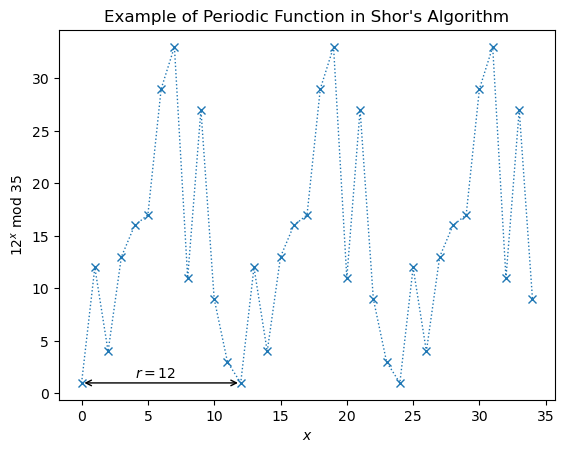

In [2]:
N = 35
a = 12

# Calculate the plotting data
lenx = 35
xvals = np.arange(lenx, dtype = int)
yvals = [np.mod(np.power(a, xvals[0]), N)]

leny = 1
while leny < lenx:
    yvals.append(np.mod(yvals[-1]*a, N))
    leny += 1
# yvals = np.mod(np.power(a, xvals), N)
# yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate('', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate('$r=%i$' % r, xy=(r/3,1.5))
    print('Value from f(0) to f(r):')
    print(yvals[:r+1])
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

<a id="Solution"></a>
### 4.1.2 - Solution: Phase estimation of an operator U

Shor's algorithm is based on implementing the phase estimation algorithm to the unitary operator:

$$
U |y \rangle \equiv | ay \, \text{mod} N \rangle
$$

By successively applying the operator $U$ to the state $|1 \rangle$ we obtain the values of $f(x)$ with $x \in \mathbb{N}$, that is,

$$
U^x |1 \rangle = | f(x) \rangle
$$

For instance, in the case of the figure ($a=3$ y $N=35$) we have:

\begin{align}
U^0 |1\rangle & = |1\rangle \\
U |1\rangle & = |3\rangle \\
U^2 |1\rangle & = |9\rangle \\
\vdots \\
U^{r-1} |1\rangle & = |12\rangle \\
U^r |1\rangle & = |1\rangle
\end{align}

(Reminder: Given a state of $n$ qubits $\left| x \right\rangle$ we have that $\left| x \right\rangle = \left| x_1 x_2 \dots x_n \right\rangle$ where $x_1$ is the most significant bit.)

As it can be noted, applying $U$ one more time is moving forward one element in the periodic list. Explicitly:
\begin{align}
U(U^0 |1\rangle) & = U(|1\rangle) = |3\rangle \\
U(U |1\rangle) & = U(|3\rangle) = |9\rangle \\
U(U^2 |1\rangle) & = U(|9\rangle) = |27\rangle\\
\vdots \\
U(U^{r-1} |1\rangle) & = U(|12\rangle) =|1\rangle \\
U(U^r |1\rangle) & = U(|1\rangle) = |3\rangle
\end{align}

With this, it is easily understood that the equiprobable superposition of all states is an eigenstate of the operator $U$ with eigenvalue 1:
$$
| u_0 \rangle = \frac{1}{\sqrt{r}} \sum^{r-1}_{k=0} |a^k \, \text{mod} N \rangle, \qquad \text{where} \quad U|u_0 \rangle = |u_0\rangle
$$

<a id="Example:-case-with-a=3-and-N=35"></a>
<details><summary><b>Example: case with $a=3$ and $N=35$ (Click for expanding)</b></summary>
<p>

\begin{align}
U |u_0 \rangle & = U \left[ \frac{1}{\sqrt{12}} \left( |1 \rangle + |3\rangle + |9 \rangle + \dots |4 \rangle + |12 \rangle \right) \right] = \\
& = \frac{1}{\sqrt{12}} \left( U|1 \rangle + U|3\rangle + U|9 \rangle + \dots U|4 \rangle + U|12 \rangle \right) = \\
& =\frac{1}{\sqrt{12}} \left( |3 \rangle + |9\rangle + |27 \rangle + \dots |12 \rangle + |1 \rangle \right) = \\
& =  |u_0 \rangle
\end{align}
</p>
</details>






An eigenstate of eigenvalue 1 is not very interesting when applying the phase estimation algorithm. Another much more interesting set of eigenstates are those of the form:
$$
| u_s \rangle = \frac{1}{\sqrt{r}} \sum^{r-1}_{k=0} e^{- \boldsymbol{2 \pi i}k \frac{s}{r}} |a^k \, \text{mod} N \rangle, \qquad \text{donde} \quad U|u_s \rangle = e^{\boldsymbol{2 \pi i} \frac{s}{r}}|u_s\rangle
$$

where $0 \leq s \leq r-1$. If we now apply the quantum phase estimation algorithm to one of these self states $|u_s \rangle$, what we will get in the count register is $|2^n s/r \rangle$. From here we can extract the value of $r$. However, in order to prepare the state $|u_s \rangle$ we have to know $r$, i.e., what we want to calculate. 

An elegant and easy way to implement this solution is to realize that the sum of all these states $|u_s \rangle$ gives us the state $|1\rangle$, that is,
$$
\frac{1}{r} \sum_{s=0}^{r-1} |u_s \rangle = \frac{1}{r} \left(|u_0 \rangle + |u_1 \rangle + \dots +|u_{r-1} \rangle \right) = | 1 \rangle.
$$

If we now apply the quantum phase estimation (QPS) algorithm to the $|1\rangle$ state (an easily implementable state) we obtain an equiprobable superposition of states of the form $|2^n s/r \rangle$, i.e:

$$ 
|0 \rangle|1 \rangle \xrightarrow{QPS} \frac{1}{\sqrt{r}} \left( \left|2^t \frac{1}{r} \right\rangle + \left|2^t \frac{2}{r} \right\rangle + \dots + \left|2^t \frac{r-1}{r} \right\rangle \right) |1 \rangle
$$

where $t$ is the number of qubits in the count register.
Using the [continued fractions](https://en.wikipedia.org/wiki/Continued_fraction) we can calculate $r$ from the quotients $s/r$.

Next circuit implements (using Qiskit's order for qubits) the Quantum Phase Estimation:

<div style="text-align:center">
<img src="Figuras_Shor/Fig-3_QPE-Shor.png" width="1000"/>
</div>



<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Note<b></span>: Let us denote <span style="color:red"> $n$ to the number of qubits needed to enconde the number $N$ </span>(the one to factorize) in a quantum register. To apply Shor's algorithm, <span style="color:red"> $t=2n$ qubits are typically used in the count register</span>.
    
</p>
</span>
</div>

<a id="Implementation-(ad-hoc)-in-Qiskit"></a>
## 4.2 - Implementation (ad hoc) in Qiskit for $N=15$

In this section we are going to see an *ad hoc* implementation of Shor's algorithm for factoring the number 15. By *ad hoc* we mean that the oracle representing the modulated exponential of the $U$ operator is built specifically for the case of factoring 15 and an explanation on that will not be provided. The goal of this section is to see how to treat the results of the circuit, applying the method of [continued fractions](https://en.wikipedia.org/wiki/Continued_fraction) to obtain $r$ and not so much to see how the oracle is constructed. 

Specifically, the case we are going to solve is the one with $a=7$ and $N=15$. It is easy to see that for this case we have a period of $r = 4$, where the four possible states are $| 1 \rangle$, $| 7 \rangle$, $| 4 \rangle$ y $| 13 \rangle$. 

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Note<b></span>: An **oracle** is, so to speak, the form used in quantum computing to name the functions from which we want to extract information by making calls to them. The oracle is a function that you don't know how it is made, you only know what it does. Like the Greek oracles, you are only allowed to question them, but not to ask them how they know that this is the answer.
In the end the oracles are represented as sections of the circuit that is dedicated to applying a $U$ operator. In our case, for example, we call the function that constructs the modulated exponential operator an oracle $U^{2^j} |y \rangle = | a^{2^j}y \, \text{mod} N \rangle$.
    
    
    
</p>
</span>
</div>

<a id="multishot"></a>
### 4.2.1 - Case with many shots (inefficient but didactic)

As the number chosen for the factorization is small (we need few qubits) we are going to throw several shots at the circuit to see all the possible results. We will see that this is actually a waste of time, since we don't need to have the whole distribution. It is simply a pedagogical case to understand how to deal with the results of the circuit.

Let us see the code (the code is taken from the [Qiskit textbook].(https://learn.qiskit.org/course/ch-algorithms/shors-algorithm)) :

Oracles:

In [3]:
# Oracle: Modular Exponentiation U^{2^j} |y> = |a^{2^j}y mod N> 
def c_amod15(a, power): # It use 4 
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

# Inverse Quantum Fourier Transformation of n qubits
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

Circuit

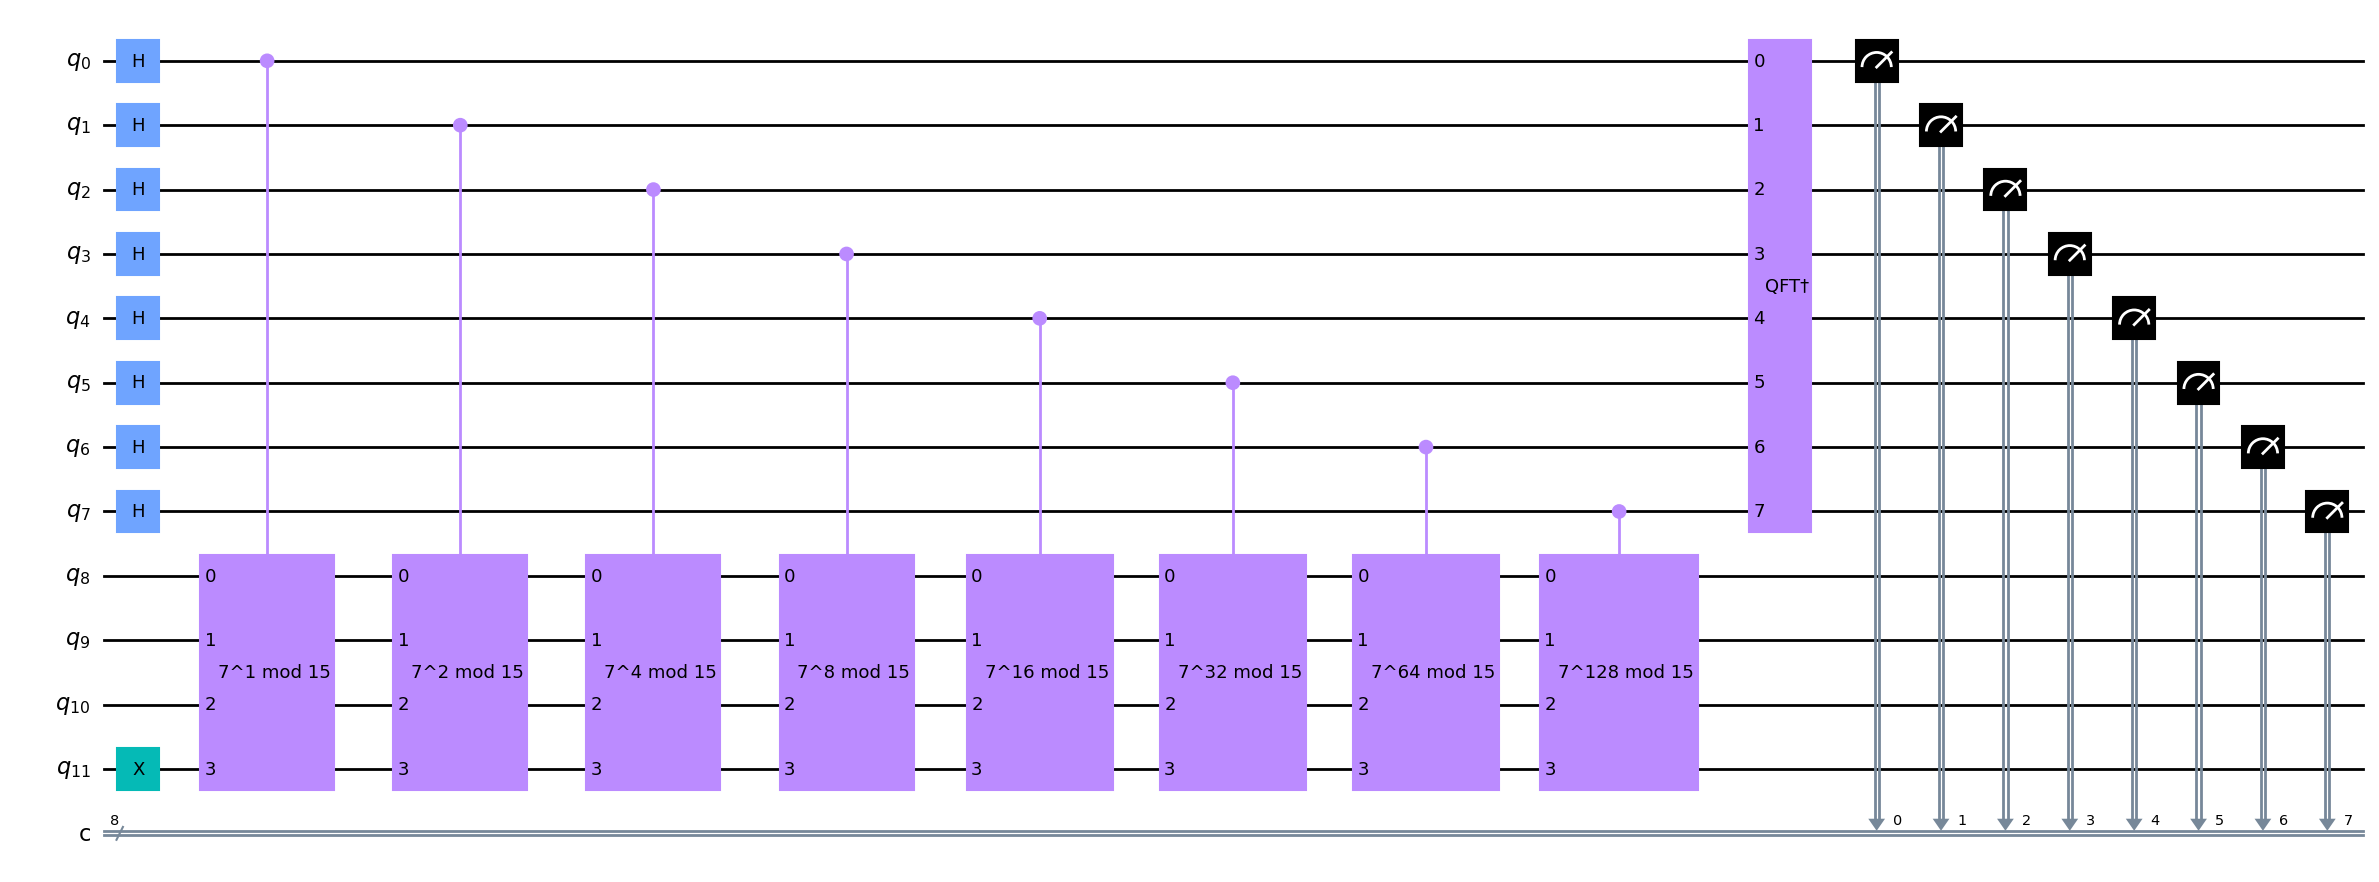

In [4]:
# Specify variables
n_count = 8  # number of counting qubits
a = 7

# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(output = 'mpl', fold=-1)  # -1 means 'do not fold'

Simulation

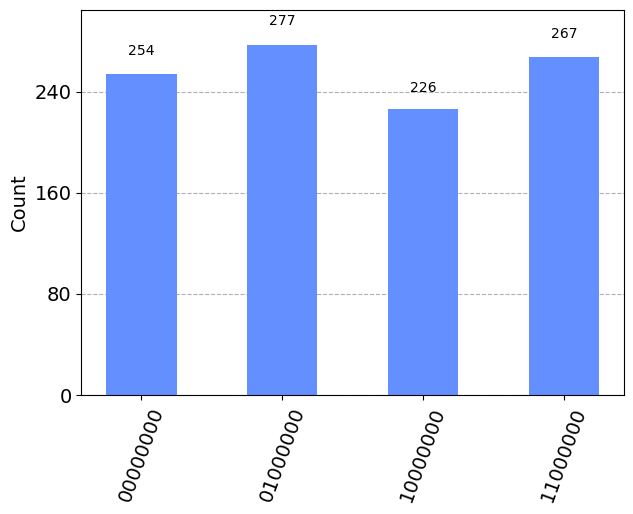

In [5]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
results = aer_sim.run(t_qc).result()
counts = results.get_counts()
plot_histogram(counts)

As we already commented, the period for the chosen case we know beforehand that it is $r = 4$. We can see that indeed, when throwing several shots to the circuit (running it several times) and seeing all the results we have 4 possibilities, corresponding to the 4 phases $s/r$ with $0 \leq s \leq r$. This is not usual when applying Shor's algorithm, because the larger the number we want to factorize, the more qubits we need, the more complex the circuit becomes and the more shots we need to reconstruct the probability distribution. 

The optimal is to launch a shot, see what value of $r$ we get with the result and try to find the divisors of $N$ with this $r$. If it does not work, we throw another shot and try to calculate $r$ again with the new result. We repeat the process until we find the factors. This will be what we will do in section [4.2.2](#shot-by-shot). 

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Note<b></span>: This is an ideal simulation, without noise. In a real quantum computer, we would have more results with low probabilities and these four would stand out.
    
    
</p>
</span>
</div>

To obtain the four values of $r$ corresponding to the four results we just obtained, we must first remember that these results are the $2^n s/r$ values for $0 \leq s \leq r$, with $s$ being an integer. The first thing we must do is convert our results from binary to decimal, then divide by $2^n$. 

Once this is done we will have real numbers between 0 and 1. We must approximate these numbers by a fraction. To do this we can use the python [Fraction()](https://docs.python.org/3/library/fractions.html) python function. Since we know that the period of the function $a^x$ mod $N$ cannot be greater than $N$, we can use Fraction().limit_denominator(N) to limit the value of the denominator. We have then:

In [6]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    frac = Fraction(phase).limit_denominator(15)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{phase:.2f}",
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print the rows in a table
headers=["Register Output", "  Phase  ", "  Fraction  ", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output   Phase     Fraction    Guess for r
0  00000000(bin) =   0(dec)      0.00          0/1            1
1  10000000(bin) = 128(dec)      0.50          1/2            2
2  11000000(bin) = 192(dec)      0.75          3/4            4
3  01000000(bin) =  64(dec)      0.25          1/4            4


Several interesting things can be noticed in this result. First, we see that the predominant choice for the period is $r=4$, which as we know, is correct (it can be seen that for $a=7$ and $N=15$ the four possible choices are $| 1 \rangle$, $| 7 \rangle$, $| 4 \rangle$ and $| 13 \rangle$). We also see that Shor's algorithm can fail. In particular, it fails when we have the state phase with $s = 0$ and when $s$ and $r$ have a common factor (in this case we have that for $s = 2 \rightarrow 2/4 \rightarrow 1/2$).

It can be seen that, besides obtaining erroneous values of $r$ by the noise (not present in our ideal simulation), Shor's algorithm can give us erroneous values of $r$. 

Now we only need to apply what is commented in section [1.4.2](#Factors-N) to calculate the factors.

<a id="shot-by-shot"></a>
### 4.2.2 - Case shot by shot (optimal)

After the didactic explanation of the previous section, we are now going to see how to make a more useful implementation. For this, instead of throwing several shots at the circuit, taking all the results (or the most probable ones if we have noise) and calculating the values of $r$, what we are going to do is to go shot by shot, calculating $r$ with each result that the circuit gives us, until we find the factors of N. Generally we will need much less shots, so it will be faster.

In [7]:
# Number to be factored
N=15

Choose a random number, $a$, between 1 and $N-1$

In [8]:
# Choose a random number, a, between 1 and N-1
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print('a = ', a)

a =  7


Verify that $a$ is not a non-trivial factor of $N$.

In [9]:
#Next we quickly check it isn't already a non-trivial factor of N
from math import gcd # greatest common divisor
gcd(a, N)

1

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Note<b></span>: Note that the greatest common divisor is calculated using the gcd() function of the [math](https://docs.python.org/3/library/math.html) python module. That is, it is computed classically (without any quantum circuitry) because, as previously commented, Euclid's algorithm is efficiently implemented in a classical order. 
    
    
</p>
</span>
</div>

We now define a function that applies the phase estimation algorithm for phase $s/r$ where

$$
a^r \text{ mod} N = 1
$$

and $s$ is a random integer between 0 and $N-1$.

In [10]:
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, aer_sim)
    result = aer_sim.run(t_qc, shots=1, memory=True).result() # One shot
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

We execute this function until the factors are found (for example, with a while loop):

In [11]:
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 01000000
Corresponding Phase: 0.250000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


<a id="Implementation-2n+3"></a>

<table width="100%">
    <td style="font-size:25px;font-family:Helvetica;text-align:left;background-color:rgba(12, 43, 337, 0.3);">
<b>5 - Implementation with 2n+3 qubits </b>
</table>

In this section we are going to see an efficient implementation of Shor's algorithm, following the paper [Circuit for Shor’s algorithm using 2n+3 qubits](https://arxiv.org/abs/quant-ph/0205095), where the aim is to minimize the number of qubits as much as possible. 

We denote <span style="color:red"> $n$ the number of qubits needed to encode the number $N$ </span>(number to factorize) in a quantum register. In order to apply Shor Algorithm <span style="color:red"> $t=2n$ qubits are used in the counting register</span>.

<a id="2n+3-Main-idea"></a>
## 5.1 - Main idea <span style="color:red"> </span> 

This section may be a bit dry if this is the first time this implementation is looked, it is oriented to be re-read once a closer look has been taken.

Let's take a step-by-step look at what this implementation looks like:

1. **Quantum addition algorithm:** As we will see in the following sections, this implementation is based on **addition**. In particular, we start from the [implementation of Draper's quantum addition algorithm](https://arxiv.org/abs/quant-ph/0008033) (see section [5.2.1](#2n+3-Addition)).
<div style="text-align:center">
<img src="Figuras_Shor/Fig-Addition-Transform.png" width="500"/>
</div >
This algorithms sums two quantum registers $a$ and $\phi (b)$, where $|\phi(x) \rangle$ refers to the Fourier transform of the register $x$:
$$
|\phi (x) \rangle = QFT \, |x \rangle.
$$

What we are going to see is how, starting from this implementation of the addition algorithm, we can construct the modulatr exponentiation.

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Important note<b></span>: Notice that the gate that the "Conditional Phase Shift" gate in the previous image is the $CROT_k$ gate of the section [2.2](#QFT-Circuit).
    
    
</p>
</span>
</div>

2. **Classical value + quantum register (gate $\boldsymbol{\phi ADD(a)}$):**  The objective is to find the period of the function $f(x) = a^x \text{ mod}N$, where $a$ is a value fixed at the beginning of the Shor algorithm. As this value is fixed, the first simplification to reduce the number of qubits is to get rid of the qubits that encode $a$ in the addition algorithm and take $a$ as a classical value. We define the gate $\boldsymbol{\phi ADD(a)}$, as the **addition of a classical value $a$ to a quantum register which encodes the value $b$** (see section [5.2.2](#2n+3-Gate-phiADD(a))):
\begin{equation}
\phi ADD(a) \, |\phi (b) \rangle = |\phi (a+b) \rangle,
\end{equation}
<div style="text-align:center">
<img src="Figuras_Shor/Fig-phiADD(a).png" width="700"/>
</div>
where $| \phi(x) \rangle$ refers to the QFT of the register $x$:
$$
|\phi (x) \rangle = QFT \, |x \rangle.
$$
We can also define the inverse of this gate, i.e. a subtraction gate (note the addition gate has the black bar on the right and the subtraction gate on the left).
<div style="text-align:center">
<img src="Figuras_Shor/Fig-phiADD(a)^-1.png" width="500"/>
</div>

3. **Modular addition (gate $\phi ADD(a)MOD(N)$):** Once defined this gate, it ca be used to construct a double-controlled gate of **modular addition** $\phi ADD(a)MOD(N)$ (see section [5.2.3](#2n+3-Gate-phiADD(a)MOD(N)))
$$
\phi ADD(a)MOD(N) |\phi (b) \rangle = |\phi \left( (a+b) \text{ mod} N \right)\rangle  = \,  QFT \, | (a+b) \text{ mod} N \rangle
$$

<div style="text-align:center">
<img src="Figuras_Shor/Fig-phiADD(a)MOD(N)_original.png" width="700"/>
</div>

4. **Modular multiplication (gate $CMULT(a)MOD(N)$)**: The double-controlled gate of modular addition can be used to build a controlled gate of **modular multiplication** $CMULT(a)MOD(N)$ (see section [5.2.4](#2n+3-Gate-CMULT(a)MOD(N)))
$$
CMULT(a)MOD(N) \, |c \rangle |x \rangle |b \rangle = |c \rangle |x \rangle | (b + a  x) \text{ mod} N \rangle, \qquad \text{si }  c = 1
$$

<div style="text-align:center">
<img src="Figuras_Shor/Fig-CMULT(a)MOD(N).png" width="700"/>
</div>

5. **Controlled gate $C\text{-}U_a$:** Combining the previous gate with a  **SWAP** gate (modular multiplication results in the register of $b$, not in $x$) and taking $b = 0$ (ancilla), we can finally construict a controlled gate $C\text{-}U_a$ such that (see section [5.2.5](#2n+3-Gate-C-U_a)):
$$
C \text{-} U_a \, |c \rangle |x \rangle = |c \rangle | (a \cdot x) \text{ mod} N \rangle, \qquad \text{si }  c = 1
$$

<div style="text-align:center">
<img src="Figuras_Shor/Fig-C-U_a.png" width="700"/>
</div>

6. **Modular exponentiation (gate $C\text{-}U_{a^{s}}$)**: In order to implement Shor algorithm, we take $ |x \rangle = | 1 \rangle$ and implement gates $C\text{-}U_{a^{s}}$, where $s$ = $2^0$, $2^1$, ..., $2^{2n-1}$, as the following holds (see section [5.2.6](#2n+3-Gate-C-U_a^s))
$$
C\text{-}U_{a^{s}} = (C\text{-}U_{a})^s
$$ 



7. **Final circuit with $4n+2$ qubits (without simplification of the counting register)**: the circuit for the Shor algorithm implementation wouldb be (see section [5.2.7](#2n+3-Final-circuit-no-simplification))
<div style="text-align:center">
<img src="Figuras_Shor/Fig-Circuito-paper.png" width="500"/>
</div>

8. **Final circuit with $2n+3$. The trick of one control qubit**: It remains to implement the simplification of the counting register, where $2n$ qubits can be substituted by just $1$ qubit (see section [5.2.8](#2n+3-Simplified-final-circuit))

<div style="text-align:center">
<img src="Figuras_Shor/Fig-Truco-qubit-control.png" width="600"/>
</div>

<a id="2n+3-Explanation-in-detail"></a>
## 5.2 - Explanation in detail

In the following subsections we will explain step by step the phases in the section [5.1](#2n+3-Main-idea)

<a id="2n+3-Addition"></a>
### 5.2.1 - Quantum algorithm addition

As we will see in the following sections, this implementation is based on **addition**. In particular, we start from the [implementation of Draper's quantum addition algorithm](https://arxiv.org/abs/quant-ph/0008033).

<div style="text-align:center">
<img src="Figuras_Shor/Fig-Addition-Transform.png" width="500"/>
</div>

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Important note<b></span>: Notice that gate "Conditional Phase Shift" of the previous image is the gate $CROT_k$ from section [2.2](#QFT-Circuit).
    
    
</p>
</span>
</div>

This algorithm sums the values $a$ and $b$. The inputs to the addition circuit are the $boldsymbol{n}$ **qubits** representing the number $a$ and $boldsymbol{n}$ **qubits** containing the Fourier transform of another number $b$, denoted as $\phi(b)$, i.e,

$$
|\phi (b) \rangle = QFT \, |b \rangle.
$$ 

The register encoding the number $a$ does not change, while the register encoding $\phi (b)$ becomes the sum of $a+b$ in Fourier space, $\phi (a+b)$. By performing the inverse transform, the value $a+b$ can be recovered:

$$
QFT^{-1}| \phi (a+b) \rangle = | a+b \rangle
$$

What we are going to see is how, starting from this implementation of the summation algorithm, we can construct the modular exponentiation.

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Nota<b></span>: Let us not lose sight of the objective. We want to calculate the period of the function $f(x) = a^x \text{mod}N$, where $a<N$ (we also take $b<N$). Having a $\text{mod}N$ we know that this function can not return values greater than $N$. We have then that the $\boldsymbol{n}$ **qubits** used to encode $a$ and $b$ are **the number of qubits needed to encode $N$**.
    
    
</p>
</span>
</div>

<a id="2n+3-Gate-phiADD(a)"></a>
### 5.2.2 - Classical value + quantum register (gate $\phi ADD(a)$)

We want to compute the period of the function $f(x) = a^x \text{ mod}N$, where $a$ is a fixed value smaller than $N$. 

Since this value is fixed, we do not need to encode it using a quantum register, so the qubits encoding $a$ can be replaced by classical bits. The controlled gates then become classically controlled gates. Moreover, since we know in advance the value of $a$, we can precompute the product of the gates on each qubit, thus applying only one gate per qubit (we reduce the depth of the circuit).

We thus define the $ ADD(a)$ gate, which **adds a classical value $a$ to the quantum register encoding the value $b$**. The input of this gate is the Fourier transform of the register $b$, i.e., $\phi (b)$, and the output is the Fourier transform of the sum, $\phi (b)$:

\begin{equation}
\phi ADD(a) \, |\phi (b) \rangle = |\phi (a+b) \rangle,
\end{equation}
<div style="text-align:center">
<img src="Figuras_Shor/Fig-phiADD(a).png" width="700"/>
</div>

As stated before, the number of qubits $n$ used to encode $a$ and $b$ is the number of qubits needed to encode $N$ (since $a$, $b$ < $N$). It may occur that when performing the addition, the result is a value greater than $N$, i.e., $a+b > N$. We could then have a number greater than the largest number we can encode with the $n$ qubits we start from. This is called **overflow**. To avoid this, an extra qubit is added to the register containing $\phi (b)$. We thus have that **$\phi(b)$ is effectively the Fourier transform of a register of $n+1$ qubits containing a number of $n$ bits**. We thus have that, before addition, **the most significant bit of the inverted QFT of the register $\phi(b)$ is always $|0\rangle$:

$$
\text{the most significat bit of } \, QFT^{-1}|\phi(b) \rangle = |b \rangle \, \text{ is always } \, |0 \rangle
$$

We can also define the inverse of this gate, i.e. a subtraction gate (note that **the addition gate has the black bar on the right and the subtraction gate on the left**).

<div style="text-align:center">
<img src="Figuras_Shor/Fig-phiADD(a)^-1.png" width="500"/>
</div>

where $p$ **is an $n$ bit** number and **$g$ is an $n+1$ bit** number. 
See that we have different results if $g \geq p$ or $g < p$. Precisely, we can use this to find out which of the two numbers is larger.
- If after subtraction the most significant bit is $|0 \rangle$, we are in the case of $g \geq p$ (**only if $g-p$ is an $n$ bit number**).
- If after subtraction the most significant bit is $|1 \rangle$, we are in the case of $p>g$.

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Note<b></span>: Apply this method with:

- $p = N \quad$ and $\quad g = b, \, a+b \quad$ (part 1 of circuit in section [5.2.3](#2n+3-Gate-phiADD(a)MOD(N)))
- $p = \, a \, \quad$ and $\quad g = b, \, a+b, \, a+b - N \quad$   (part 2 of the circuit in section [5.2.3](#2n+3-Puerta-phiADD(a)MOD(N)))
    
    
In both cases we have that $p$ is an $n$ bit number and if $g \geq p$ we have $g-p < N$, so $g-p$ is $n$ bit. We can then apply the most significant bit criterion to find out which number is larger. 
</p>
</span>
</div>

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Note<b></span>: If $g<p$ then:

$$
\phi ADD^{-1}(p) \, | \phi(g) \rangle = |\phi (2^{n+1} - (p-g)) \rangle
$$

If $p$ is added once again $p$ we obtain:
    
$$
\phi ADD(p) \, |\phi (2^{n+1} - (p-g)) \rangle =  |\phi (2^{n+1} - (p-g)) + p \rangle =  |\phi (2^{n+1} + g)) \rangle
$$

As $2^{n+1} + g$ is greater than the maximum value possible value using $n+1$ qubits, overflow occurs:

$$
\phi ADD(p) \, |\phi (2^{n+1} - (p-g)) \rangle = |\phi (2^{n+1} + g)) \rangle = |\phi (g) \rangle
$$

Hence, \phi ADD(p)$ and $\phi ADD^{-1}(p)$ are the inverse of each other.
    
</p>
</span>
</div>

<a id="2n+3-Gate-phiADD(a)MOD(N)"></a>
### 5.2.3 - Modular addition (puerta $\phi ADD(a)MOD(N)$)

Once the addition gate $\phi ADD(a)$ is defined, we can use it to construct a **modular addition gate** $\phi ADD(a)MOD(N)$. This gate performs $a+b$ and subtracts $N$ from it if $a+b \geq N$. The inputs are $\phi(b)$ with $b < N$ and a classical value $a < N$.

$$
\phi ADD(a)MOD(N) |\phi (b) \rangle = |\phi \left( (a+b) \text{ mod} N \right)\rangle  = \,  QFT \, | (a+b) \text{ mod} N \rangle
$$

<div style="text-align:center">
<img src="Figuras_Shor/Fig-phiADD(a)MOD(N)-English.png" width="700"/>
</div>

Two control qubits ($| c_1 \rangle$, $| c_2 \rangle$) have been added for future use. The gate is only activated if $c_1 = c_2 = 1$. The gates have been numbered (red boxes) for ease of explanation.



<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Important Note<b></span>: The [paper](https://arxiv.org/abs/quant-ph/0205095) from which the figures are taken mixes the two qubit ordering conventions in the circuits. The figure above uses **the same as the one used by Qiskit**, where the most significant bit is the bottom bit. For that reason the CNOTs that are applied in the bottom qubit are controlled by the last qubit, the $| \phi (b) \rangle$ register.

</p>
</span>
</div>

As it can be noticed in the image, the circuit implementing that gate consists of two parts:
- Part 1: Computes $(a+b) \text{ mod} N$
- Part 2: Returns the ancilla qubit to the state $|0 \rangle$ (qubit at the bottom of the image).

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Note<b></span>: An **ancilla** qubit is an auxiliary qubit that is used to do an intermediate calculation but is not part of the solution. These qubits must be reset to the initial state. 
</p>
</span>
</div>

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Important note<b></span>: The ancila qubit **is not an extra register qubit** $| \phi (b) \rangle$. There are 2 control qubits, the $n+1$ of the input $| \phi (b) \rangle$ and the ancila qubit, hence $n+4$ qubits are used.
    
    
</p>
</span>
</div>

Let us look at all the possible cases we may encounter.

#### 5.2.3.1 - Case $\boldsymbol{c_1 = c_2 = 1}$

Start with state $| \phi(b) \rangle$.

- **Gate 1**: After applying gate 1 (gate $\phi ADD(a)$) the state is obtained $| \phi(a+b) \rangle$.

- **Gates 2, 3, 4 y 5**: Check whether we are in the case $a+b \geq N$ or $a+b <N$. To do so, apply the gate $\phi ADD^{-1}(N)$ (gate 2), hence:
\begin{align}
    & \text{1) State $| \phi(a+b - N) \rangle$ if $a+b \geq N$} \\
    & \text{2) State $| \phi(2^{n+1} -(a+b - N)) \rangle$ if $a+b < N$.}
\end{align} 
    Gates 3, 4 and 5 change ancilla qubit to 1 if most significant bit is 1, i.e, if we are in the second case. 

- **Gate 6**: This gate is only activated if the ancilla qubit is 1, i.e., if we are in the second case of the previous step ($a+b < N$). What this gate does is adding $N$, undoing the subtraction of gate 2 if we are in the case $a+b < N$, that is, if subtracting $N$ did not have to be done. After this gate we already have the result of the modular addition. It only remains to return ancilla qubit to state $|0\rangle$.


- **Gate 7**: Start with state $(a+b) \text{ mod} N$. This gate sums $a$, hence we have two cases:
\begin{align}
    & \text{3) $(a+b) > N \quad \Rightarrow \quad (a+b) \text{ mod} N = a+b-N < a \quad \Rightarrow $} \\ 
    & \qquad \quad \Rightarrow \quad \phi ADD^{-1}(a) \, | \phi ((a+b) \text{ mod} N) \rangle = | \phi ( 2^{n+1} - (N - b) ) \rangle  \\
    & \text{4) $(a+b) < N \quad \Rightarrow \quad (a+b) \text{ mod} N = a+b > a \quad \Rightarrow $} \\ 
    & \qquad \quad \Rightarrow \quad \phi ADD^{-1}(a) \, | \phi ((a+b) \text{ mod} N) \rangle = | \phi ( b ) \rangle  \\
\end{align} 

- **Gates 8, 9, 10, 11, 12**: These gates change the old gate if the most significant bit is zero. We see that this is case 4 of the previous step, that is, when $(a+b) < N$. Notice that applying gates 2, 3, 4 and 5 corresponds to case 2, the one where just the ancilla is changed. That is, if we had changed the ancilla, we would now have set it back to zero.

- **Gate 13**: Undoes the change produced by gate 7.

#### 5.2.3.2 - Case $\boldsymbol{c_1 = 0}$ y/o $\boldsymbol{c_2 = 0}$

In these cases gate $\phi ADD(a)MOD(N)$ remains the input invariant.

Start with state $| \phi(b) \rangle$.

- **Gate 1**: Not applying. 

- **Gate 2**: Substract $N$, hence the state in register is $\phi \left( 2^{n+1} - (N-b) \right)$.

- **Gates 2, 3, 4 y 5**: As the most significant bit in this case is always 1, these gates set the ancilla qubit to 1.

- **Gate 6**: As ancilla qubit is 1, this gates activates and undoes the changes produced by gate 2. The initial state $| \phi(b) \rangle$ is again in the register but qubit ancilla set to 1.

- **Gate 7**: Not applying.

- **Gates 8, 9, 10, 11, 12**: As mentioned before, these gates change the ancilla if the incoming state has the most significant bit set to zero. As the state is $| \phi(b) \rangle$, this is the case so the ancilla is changed again. We go back to the initial state, without any change.

- **Gate 13**: Not applying.

<a id="2n+3-Gate-CMULT(a)MOD(N)"></a>
### 5.2.4 - Modular Multiplication (gate $CMULT(a)MOD(N)$)

Next step is using $\phi ADD(a)MOD(N)$ to construct a controlled modular multiplication gate, denoted $CMULT(a)MOD(N)$. The entry of this gate will be three registers $|c \rangle |x \rangle |b  \rangle$, where $|c \rangle$ is a control qubit:
 - $CMULT(a)MOD(N) \, |c \rangle |x \rangle |b \rangle = |c \rangle |x \rangle | (b + a x) \text{ mod} N \rangle, \qquad \, \text{if }  
 c = 1$
 
 - $CMULT(a)MOD(N) \, |c \rangle |x \rangle |b \rangle = |c \rangle |x \rangle | b \rangle, \qquad \qquad \qquad \quad \phantom{i} \text{if }  c = 0$
 
To implement this gate the gates from previous section $\phi ADD(a)MOD(N)$ are used

\begin{align}
(ax) \text{ mod} N & = (2^0 a x_0 + 2^1 a x_1 + \dots + 2^{n-1} a x_{n-1}) \text{ mod} N \\
& = \{\dots [(2^0 a x_0) \text{mod} N + 2^1 a x_1] \text{ mod} N + \dots + 2^{n-1} a x_{n-1}\} \text{ mod} N
\end{align}

It is easy to understand this identity: it is the same to add all the terms and finally take modulo of the complete sum as it is to take modulo of the first term, add it to the second term, take modulo again, and so on. We see that this can be implemented by first applying a $\phi ADD(2^0 a) MOD(N)$ gate over $|b \rangle$ controlled by $|c \rangle$ and $|x_0 \rangle$, then a $\phi ADD(2^1 a) MOD(N)$ gate over the result of the previous one controlled by $|c \rangle$ and $| x_1 \rangle$, and so on. Whereupon, **we only need to apply $n$ doubly controlled gates $\phi ADD (2^i a) MOD(N)$** with $0 \leq i < N$. We can see this implementation in the following figure.

<div style="text-align:center">
<img src="Figuras_Shor/Fig-CMULT(a)MOD(N).png" width="700"/>
</div>





<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Important note<b></span>: The [paper](https://arxiv.org/abs/quant-ph/0205095) from which the figures are taken mixes the two qubit ordering conventions in the circuits. The figure above uses **the same as the one used by Qiskit**, where the most significant bit is the bottom bit. For that reason, the qubit of the register $|x \rangle$ controlling the gate $\phi ADD(2^0 a)MOD(N)$ is the first, the one controlling the gate $\phi ADD(2^{n-1} a)MOD(N)$ is the last, ....

</p>
</span>
</div>

<a id="2n+3-Gate-C-U_a"></a>
### 5.2.5 - Controlled gate $C\text{-}U_a$

In the previous section we saw how to build a controlled gate applying the operation

$$
| x \rangle | b \rangle | b \rangle | (b+ax) \text{ mod}N \rangle
$$

But this is not what we want, we want a controlled gate that transforms the state $|x \rangle$ to the state $| (ax) \text{ mod} \rangle$. It can be solved as follows:
 - First apply a gate $CMULT(a)MOD(N)$ on the state $|c \rangle |x \rangle |0 \rangle$, whereupon we obtain the state $|c \rangle |x \rangle | (ax) \text{ mod} N \rangle$. 
 
 - Next, if $|c \rangle = | 1 \rangle$ we apply controlled SWAP gates to change the registers $|x \rangle$ and $|(b + ax) \text{ mod} N \rangle$, whereupon we get the state $|c \rangle |(ax) \text{ mod} N \rangle |x \rangle$. We only need to apply SWAP controlled gates to $n$ qubits, not to $n+1$, since the most significant qubit of $(ax) \text{ mod}N$ is always 0, as it is the extra qubit we include to avoid overflow in the $\phi ADD (a)$ gates. 
 
 - Finally, we apply the inverse of the controlled gate $CMULT(a^{-1}) MOD(N)$, where $a^{-1}$ is the inverse of $a$ modulo N. This value is classically computed in polynomial time using Euclid's algorithm and we are assured that it always exists since $gcd(a,N) =1$. In summary, if the input to this gate is the state $|c \rangle | x \rangle | b \rangle$ with $|c \rangle = |1 \rangle$ we have:
 $$
 [CMULT(a^{-1}) MOD(N)]^{-1} |c \rangle | x \rangle | b \rangle = |c \rangle | x \rangle | (b - a^{-1}x \rangle
 $$
 In our case we have that the input state is $|c \rangle |(ax) \text{ mod} N \rangle |x \rangle $$, whereupon:
 
$$
[CMULT(a^{-1}) MOD(N)]^{-1} |c \rangle |(ax) \text{ mod} N \rangle |x \rangle = |c \rangle |(ax) \text{ mod} N \rangle |(x - a^{-1} ax )\text{ mod} N \rangle = |c \rangle |(ax) \text{ mod} N \rangle | 0 \rangle
$$

Denote the set of these three controlled gates as **controlled gate $U_a$**, i.e., $C\text{-}U_a$. In sumarry, this gate transforms $| c \rangle | x \rangle |0 \rangle$ into  $| c \rangle | (ax) \text{ mod} N  \rangle |0 \rangle$ if $c=1$:

$$
C\text{-}U_a | c \rangle | x \rangle |0 \rangle = | c \rangle | (ax) \text{ mod} N  \rangle |0 \rangle \qquad \text{ if } c = 1
$$

If $c=0$, identity is applied. 

In summary, the gate $C\text{-}U_a$ realizes the following steps (if $|c \rangle = | 1 \rangle$)

\begin{align}
& | x \rangle | 0 \rangle  \quad \rightarrow \quad |x \rangle | (ax) \text{ mod}N \rangle \quad \rightarrow \quad  | (ax) \text{ mod}N \rangle |x \rangle \quad \rightarrow \\
&\rightarrow \quad | (ax) \text{ mod}N \rangle  | (x - a^{-1}ax) \text{ mod}N \rangle = | (ax) \text{ mod}N \rangle | 0\rangle
\end{align}

<div style="text-align:center">
<img src="Figuras_Shor/Fig-C-U_a.png" width="700"/>
</div>

Notice that, in the last register, as it is $|0 \rangle$ at the beginning and at the end, it can be considered part of the gate $C\text{-}U_{a}$ (ancila):

$$
C\text{-}U_a | x \rangle |0\rangle = |(ax) \text{ mod} N \rangle |0 \rangle \quad \Rightarrow \quad C\text{-}U_a | x \rangle  = |(ax) \text{ mod} N \rangle
$$

<a id="2n+3-Gate-C-U_a^s"></a>
### 5.2.6 - Modular Exponentiation (gate $C\text{-}U_{a^{s}}$)

Once the $C\text{-}U_{a}$ gate has been constructed, one might think that to apply the modular exponentiation this gate has to be applied several times, that is:

$$
\left( C\text{-}U_a \right)^s  | x \rangle  = |(a^s x) \text{ mod} N \rangle
$$

Although this implementation is possible, we have the option to make a much more optimal one. For this we use the property 

$$
(a^s x) \text{ mod} N = \underbrace{\{ \dots [a(ax) \text{ mod}N] \text{ mod}N \dots \}\text{ mod}{N}}_{s \text{ veces}} = [x (a^s)\text{ mod}N ] \text{ mod}N
$$

Instead of applying $s$ times the gate $C\text{-}U_{a}$ we can apply only once the gate $C\text{-}U_{a^s}$ where the subscript $a^s$ means that we pass to the gate the value $a^s \text{ mod} N$ (this is classically calculated).

$$
C\text{-}U_{a^{s}} = (C\text{-}U_{a})^s
$$ 

<a id="2n+3-Final-circuit-no-simplification"></a>
### 5.2.7 - Final circuit with $4n+2$ qubits (without the simplification of the counting register)

It only remains for us to see the circuit with the complete implementation of Shor's algorithm. (Recall that $n$ is the number of qubits we need to encode $N$ and that in the count register we need $2n$ qubits.)


<div style="text-align:center">
<img src="Figuras_Shor/Fig-Circuito-paper.png" width="500"/>
</div>

This implementation uses $4n+2$ qubits:
  - $2n$ qubits in the counting register.
  - $n$ qubits for the state $|1\rangle$ (i.e., the state $|x \rangle$ of sections [5.2.4](#2n+3-Gate-CMULT(a)MOD(N)) to [5.2.6](#2n+3-Puerta-C-U_a)).
  - $n+2$ qubits for ancillas:
      - $n+1$ qubits for the state $|b \rangle = | 0 \rangle$ (see figures of sections [5.2.4](#2n+3-Gate-CMULT(a)MOD(N)) y [5.2.5](#2n+3-Puerta-C-U_a)).
      - 1 qubit for the ancilla of the gate $\phi ADD(a)MOD(N)$ (see figure of section [5.2.3](#2n+3-Gate-phiADD(a)MOD(N))).

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Important note<b></span>: The [paper](https://arxiv.org/abs/quant-ph/0205095) from which the figures are taken mixes the two qubit ordering conventions in the circuits. The figure above uses **the same as the one used by Qiskit**, where the most significant bit is the bottom bit. For that reason, the qubit which controls gate $U_{a^0}$ is the last one, the one which controls gate $U_{a^{2n-1}}$ is the first one,...

</p>
</span>
</div>

<a id="2n+3-Simplified-final-circuit"></a>
### 5.2.8 - Final circuit with $2n+3$. The trick of one control qubit

It remains to implement the simplification of the count register, where the number of qubits is reduced from $2n$ to 1.

<div style="text-align:center">
<img src="Figuras_Shor/Fig-Truco-qubit-control.png" width="600"/>
</div>

Each measured bit dictates which unit transformation has to be applied after each U-controlled step before the next measurement.

We will not go further into this simplification, we refer the reader to the papers [[9]](http://arxiv.org/abs/quant-ph/9903071), [[10]](https://arxiv.org/abs/quant-ph/9806084) y [[11]](https://arxiv.org/abs/quant-ph/0001066).

<a id="2n+3-QFT"></a>
## 5.3 - Aproximated implementation of QFT.

We already saw in section [2.2](#QFT-Circuit) the implementation of the quantum Fourier transform. Here we present again the same implementation but with the gate notation that we have been using in this section:

<div style="text-align:center" >
<img style="width:500" src="Figuras_Shor/Fig-qft.png"/>
</div>

<div class="warning" style='padding:0.1em; background-color:#E0FFFF; color:#69337A'>
<span>
<p style='margin-left:1em;'>

<span style="color:red"><b>Important note<b></span>: Notice that the differences between this picture and the one in section [2.2](#QFT-Circuit) are simply the change of notation of the $UROT_k$ gates and that the Swap gates at the end are missing. This is simply because in section [2.2](#QFT-Circuit) the Qiskit convention was used for the ordering of the qubits, while in this section the usual one is being used. 
 
</p>
</span>
</div>

This is the exact implementation of QFT which, as we see the picture, when we apply it to $n$ qubits we need on the order of $\mathcal{O} (n^2)$ operations (in particular, it is $\frac{1}{2} n(n+1)$ operations). 

Remainder: The matrix expression of gates $CROT_k$

$$
CROT_k = \left[ \begin{matrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & \exp \left( \frac{2 \pi i}{2^k} \right)
\end{matrix} \right]
$$

It can be seen that when $k$ grows very large, the $CROT_k$ gates approach the Identity. This makes that we can dispense with gates with $k$ value larger than a certain threshold $k_{max}$ and thus apply an **approximate** version (with fewer operations) of the Fourier transform. It can be shown (see [12](https://arxiv.org/abs/quant-ph/0201067)) that the error introduced by ignoring all gates with value $k > k_{max}$ is proportional to $n 2^{-k_{max}}$. We can thus take $k_{max}$ of order $\mathcal{O} (\log_2 n)$, going from having of order $\mathcal{O} (n^2)$ operations (gates) to $\mathcal{O} (n \log_2(n))$ operations (in particular $\frac{1}{2} (2n-\log_2n)(\log_2n-1)$ operations]).


<a id="2n+3-SWAP"></a>
## 5.4 - Implementaction of controlled SWAP gates

The controlled *SWAP* is a gate that supports three qubits (one for control and two for operation), and is constructed as follows:

<div style="text-align:center" >
<img style="width:800" src="Figuras_Shor/Fig-swap.png"/>
</div>

Two *CNOT* gates surrounding a *Toffoli* gate. The role of this gate is to exchange the value of the two operating qubits if the control qubit is activated. As we can see, to swap two qubits we need 3 gates, so the gates needed to apply a controlled *SWAP* gate to $n$ qubits are $\mathcal{O}(n)$ gates.

We see that the controlled *SWAP* gate is not the same as the normal *SWAP* gate (three *CNOT* gates) where the central *CNOT* gate is controlled, making it a *Toffoli* gate.

<a id="References"></a>
## References

1. Beauregard, S. (2002). Circuit for Shor's algorithm using 2n+ 3 qubits, [quant-ph/0205095](https://arxiv.org/abs/quant-ph/0205095).

2. [Quantum Fourier Transform (textbook Qiskit)](https://learn.qiskit.org/course/ch-algorithms/quantum-fourier-transform)

3. [Quantum Phase Estimation (textbook Qiskit)](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation)

4. [Shor's Algorithm (textbook Qiskit)](https://learn.qiskit.org/course/ch-algorithms/shors-algorithm)

5. [Continued fraction (Wikipedia)](https://en.wikipedia.org/wiki/Continued_fraction)

6. [Algoritmo de Euclides](https://en.wikipedia.org/wiki/Euclidean_algorithm)

7. Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information: 10th Anniversary Edition (10th. ed.). Cambridge University Press, USA

8. Draper, T. G. (2000). Addition on a quantum computer, [quant-ph/0008033](https://arxiv.org/abs/quant-ph/0008033).

9. Mosca, M., & Ekert, A. (1998, February). The hidden subgroup problem and eigenvalue estimation on a quantum computer. In NASA International Conference on Quantum Computing and Quantum Communications (pp. 174-188). Springer, Berlin, Heidelberg. [quant-ph/9903071](http://arxiv.org/abs/quant-ph/9903071)

10. Zalka, C. (1998). Fast versions of Shor's quantum factoring algorithm.  [quant-ph/9806084](https://arxiv.org/abs/quant-ph/9806084).

11. Parker, S., & Plenio, M. B. (2000). Efficient factorization with a single pure qubit and log N mixed qubits. Physical Review Letters, 85(14), 3049. [quant-ph/0001066](https://arxiv.org/abs/quant-ph/0001066)

12. Coppersmith, D. (2002). An approximate Fourier transform useful in quantum factoring. arXiv preprint [quant-ph/0201067](https://arxiv.org/abs/quant-ph/0201067).

In [3]:
%qiskit_version_table

This work has been financially supported by the Ministry of Economic Affairs and Digital Transformation of the Spanish Government through the QUANTUM ENIA project call - Quantum Spain project, and by the European Union through the Recovery, Transformation and Resilience Plan - NextGenerationEU within the framework of the Digital Spain 2025 Agenda.


<img align="left" src="https://quantumspain-project.es/wp-content/uploads/2022/11/LOGOS-GOB_QS.png" width="1000px" />